<a href="https://colab.research.google.com/github/keisukecl/WorldAI_Yamaguchi/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

これは["ワールドＡＩコンペティション　ＹＡＭＡＧＵＣＨＩ"](https://signate.jp/competitions/1219)のチュートリアルです. 前分析とモデリングをして, コンペティションで提出するファイルの作成までの流れの一例を説明します. 分析やアルゴリズムの実装の参考になれば幸いです. 内容は以下の通りです.

- [前分析](#前分析)
- [モデリング](#モデリング)
- [応募用ファイルの作成と動作と精度の確認](#応募用ファイルの作成と動作と精度の確認)
- [参考文献](#参考文献)

分析環境は以下の通りです.

- Python==3.9
- 主なライブラリ
  - Pillow==10.0.0
  - torch==2.0.1
  - timm==0.9.7
  - torchvision==0.15.2
- GPU: nvidia製でメモリは8GB程度以上

環境の構築が難しいようであれば"GoogleColaboratory"も活用してみてください.  
なお, 本ノートブックは[データタブ](https://signate.jp/competitions/1219/data)よりダウンロード可能です(`tutorial.ipynb`).

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 前分析

画像データとアノテーションデータの中身を確認し, 可視化などを行います. 内容は以下の通りです.

1. [画像データの確認](#画像データの確認)
1. [アノテーションデータの確認](#アノテーションデータの確認)

あらかじめ学習用データ(`train.zip`)をこのチュートリアルノートブックと同じディレクトリに展開してください. 解凍すると以下のようなディレクトリが生成されます.

```bash
train
├─ 00000.jpg
├─ 00000.json
└─ ...
```

まずは必要なライブラリのインポートを行います.

In [18]:
import os
import json
from PIL import Image, ImageFont, ImageDraw
# prompt: このファイルが今どこにあるか確認する
print(os.getcwd())
train_dir = './train/'

/content


In [19]:
import zipfile
import shutil

with zipfile.ZipFile('/content/drive/MyDrive/WorldAICompe_YAMAGUCHI/train.zip') as zf:
    zf.extractall()

In [20]:
DIR = './train'
print(sum(os.path.isfile(os.path.join(DIR, name)) for name in os.listdir(DIR)))

71134


### 画像データの確認

縦×横やチャンネル数を確認します. ここでは`00000.jpg`を確認します.

In [21]:
img_path = os.path.join(train_dir, '00000.jpg')
img = Image.open(img_path)
print('width, height: ', img.size)
print('mode:', img.mode)

width, height:  (260, 1262)
mode: RGB


画像はRGB形式なので, チャンネル数は3です. この画像を可視化します.

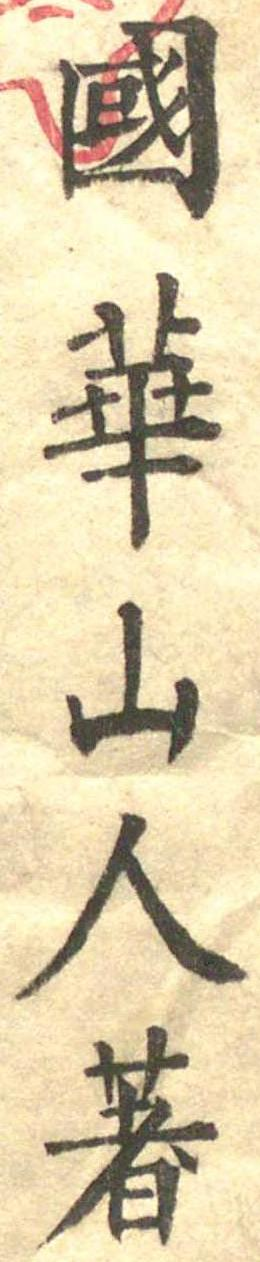

In [22]:
img

ある一行の画像です. 他の画像も確認してみてください.

学習データとして与えられる画像数や縦, 横の長さなどの平均や最大値を見てみます.

In [23]:
def describe(image_dir:str):
    count = 0
    height = 0
    width = 0
    max_height = 0
    max_width = 0
    max_aspect_ratio = 0
    for img_path in os.listdir(image_dir):
        if os.path.splitext(img_path)[-1] == '.jpg':
            img = Image.open(os.path.join(train_dir, img_path))
            count += 1
            width += img.size[0]
            height += img.size[1]
            max_width = max(img.size[0], max_width)
            max_height = max(img.size[1], max_height)
            max_aspect_ratio = max(img.size[1]/img.size[0], max_aspect_ratio)
    print('画像数: ', count)
    print('縦:', height/count)
    print('横:', width/count)
    print('縦の最大値:', max_height)
    print('横の最大値:', max_width)
    print('アスペクト比の最大値:', max_aspect_ratio)

In [24]:
describe(train_dir)

画像数:  35567
縦: 2191.986166952512
横: 170.7284280372255
縦の最大値: 4486
横の最大値: 531
アスペクト比の最大値: 32.657534246575345


縦長の画像です.

### アノテーションデータの確認

アノテーションデータの中身を確認します. ここでは`00000.json`を確認します. これは`00000.jpg`に対するアノテーションとなります.

In [25]:
annotation_path = os.path.join(train_dir, '00000.json')
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)

アノテーションデータのフォーマットは以下の通りです(配布されている`readme.md`を確認してください).

```json
{
    "book_id": book_id,
    "page_id": page_id,
    "text": text,
    "labels": [
        {
            "label": label,
            "bbox": [
                left,
                top,
                right,
                bottom
            ]
        },
        ...
    ]
}
```
`book_id`は書籍IDで, `page_id`はその書籍のページIDに対応している. `text`はくずし字を上から読んだ結果で, `labels`はそれぞれのくずし字の文字情報(`label`)と矩形情報(`bbox`)のリストである. 矩形情報は画像の左上を原点として左上の座標と右下の座標によって表現される(`left`: 左, `top`: 上, `right`: 右, `bottom`: 下).

上記で確認した画像に対してアノテーションと一緒に可視化します. フォントファイルをあらかじめ`font_path`に設置しておく必要があります.

In [26]:
def vis_annotation(img, ann, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)     # PILでフォントを定義
    draw = ImageDraw.Draw(img)
    for label in ann['labels']:
        draw.text(xy=(label['bbox'][0]-font_size, int((label['bbox'][1]+label['bbox'][3])/2)), text=label['label'], font=font, fill=(255,0,0))
        draw.line((label['bbox'][0], label['bbox'][1], label['bbox'][2], label['bbox'][1]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][1], label['bbox'][2], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][3], label['bbox'][0], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][0], label['bbox'][3], label['bbox'][0], label['bbox'][1]), fill=(255, 0, 0), width=1)
    print(ann['text'])
    return img

国華山人著


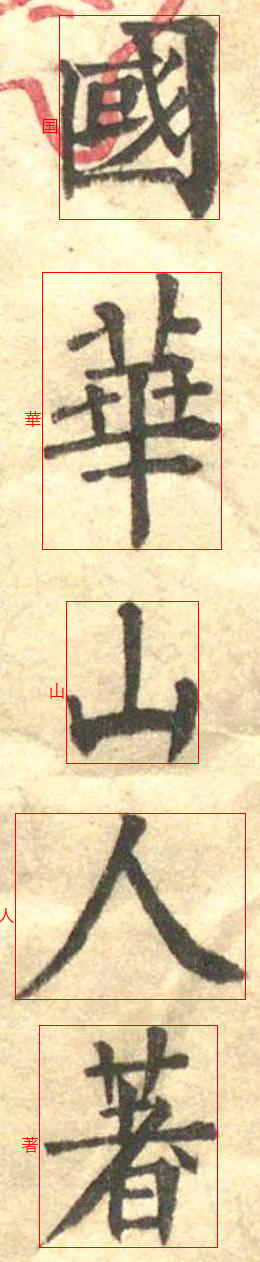

In [27]:
font_path = '/content/drive/MyDrive/WorldAICompe_YAMAGUCHI/YuGothM.ttc'                          # フォントファイルへのパス
font_size = 18                                      # フォントサイズの指定
img = vis_annotation(img, ann, font_path, font_size)
img

他の画像とアノテーションも確認してみてください.

学習データに存在する文字種の総数とそれぞれの出現頻度を見てみます.

In [28]:
def check_characters(img_dir:str):
    characters = {}
    # book_idの種類を格納するセットを作成
    book_id_set = set()
    for ann_path in os.listdir(img_dir):
        if os.path.splitext(ann_path)[-1] == '.json':
            with open(os.path.join(train_dir, ann_path), encoding='utf-8') as f:
                ann = json.load(f)
            for character in ann['text']:
                if character not in characters:
                    characters[character] = 1
                else:
                    characters[character] += 1
             # 各要素のbook_idをセットに追加
            book_id_set.update(ann['book_id'] for item in ann)

    # 種類数を出力
    print(f'book_idの種類数: {len(book_id_set)}')
    print('各book_id:', book_id_set)
    print('文字種数:', len(characters))
    print('\n出現頻度Top10:')
    for d in sorted(characters.items(), key=lambda x:x[1], reverse=True)[:10]:
        print(' ', d[0], d[1])
    print('\n出現頻度Worst10:')
    for d in sorted(characters.items(), key=lambda x:x[1])[:10]:
        print(' ', d[0], d[1])

In [29]:
check_characters(train_dir)

book_idの種類数: 30
各book_id: {'012', '007', '027', '011', '020', '003', '015', '025', '002', '023', '010', '005', '026', '000', '014', '024', '016', '028', '019', '004', '013', '006', '021', '018', '008', '022', '001', '009', '029', '017'}
文字種数: 3968

出現頻度Top10:
  の 27055
  に 25198
  し 24205
  て 19644
  を 17292
  と 15545
  か 15533
  り 15526
  は 15016
  な 14358

出現頻度Worst10:
  厘 1
  蛥 1
  鰲 1
  犇 1
  芡 1
  慫 1
  蘰 1
  蘋 1
  潦 1
  頌 1


出現頻度にかなり偏りがあります.

## モデリング

画像データに対して書かれているくずし字を認識する深層学習モデルを構築し, 予測結果を可視化したり精度を確認します. 内容は以下の通りです.

1. [学習用データの作成](#学習用データの作成)
1. [画像の読み込みと前処理を行うインスタンスの作成](#画像の読み込みと前処理を行うインスタンスの作成)
1. [深層学習モデルの構築](#深層学習モデルの構築)
1. [深層学習モデルの学習](#深層学習モデルの学習)
1. [深層学習モデルによる予測](#深層学習モデルによる予測)

### 学習用データの作成

まずは準備として特定の書籍IDのデータを選択して学習用データとして作成し, エンコード用とデコード用に文字ラベルを作成します.

In [30]:
import json
import shutil

dryrun = True

In [31]:
import json
import os
import shutil

def make_data(src_img_dir, dst_img_dir, book_id_list, dryrun=False):
    # もとの画像データが格納されているディレクトリを表示
    print('\n' + src_img_dir)

    # コピーされたサンプル数の初期化
    count = 0

    # キャラクターラベルの集合を初期化
    character_labels = set()

    # 対象ディレクトリ内の各ファイルに対して処理
    for fname in os.listdir(src_img_dir):
        sname, ext = os.path.splitext(fname)

        # ファイルの拡張子が .json の場合
        if ext == '.json':
            # JSONファイルを読み込む
            with open(os.path.join(src_img_dir, fname)) as f:
                ann = json.load(f)

            # JSONファイルに含まれる book_id が指定されたリストに含まれている場合
            if ann['book_id'] in book_id_list:
                # JSONファイルとそれに関連する画像ファイルをコピー
                shutil.copy(os.path.join(src_img_dir, fname), os.path.join(dst_img_dir, fname))
                shutil.copy(os.path.join(src_img_dir, sname + '.jpg'), os.path.join(dst_img_dir, sname + '.jpg'))

                # JSONファイルに含まれる text フィールドの各要素をキャラクターラベルとして追加
                for w in ann['text']:
                    character_labels.add(w)

                # コピーされたサンプル数が1000の倍数の場合、途中経過を表示
                if count % 1000 == 0:
                    print('{} samples copied to {}'.format(count, dst_img_dir))

                # コピーされたサンプル数を増やす
                count += 1

                #dryrun時は画像を10枚に絞っておく
                if dryrun == True and count == 10:
                    break

    # キャラクターラベルをインデックスに変換する辞書を作成
    index2character = {i + 1: s for i, s in enumerate(character_labels)}
    character2index = {v: k for k, v in index2character.items()}

    # インデックス変換の辞書をJSONファイルとして保存
    with open('./index2character.json', 'w', encoding='utf-8') as f:
        json.dump(index2character, f, ensure_ascii=False, indent=4)
    with open('./character2index.json', 'w', encoding='utf-8') as f:
        json.dump(character2index, f, ensure_ascii=False, indent=4)

    # 最終的なコピーされたサンプル数を表示
    print('{} samples copied to {}'.format(count, dst_img_dir))

書籍ID'000','001','002','003', '004', '005', '006', '007', '008', '009'を選択して作成してみます.

In [32]:
dst_img_dir = './train_data'
os.makedirs(dst_img_dir, exist_ok=True)
book_id_list=['000', '001', '002', '003', '004', '005', '006', '007', '008', '009']
make_data(train_dir, "./train_data", book_id_list, dryrun=True)


./train/
0 samples copied to ./train_data
10 samples copied to ./train_data


以下のようなデータが作成されます.

```bash
train_data
├─ 0000.jpg
├─ 0000.json
└─ ...
```

`./index2character.json`

```bash
{
    "1": character1,
    "2": character2,
    ...
}
```

`./character2index.json`

```bash
{
    character1: 1,
    character2: 2,
    ...
}
```

画像の縦と横の長さなどの平均や最大値を見てみます.

In [33]:
describe(dst_img_dir)

画像数:  10
縦: 1956.7
横: 175.5
縦の最大値: 2658
横の最大値: 286
アスペクト比の最大値: 15.89937106918239


文字種の数を確認します.

In [34]:
check_characters(dst_img_dir)

book_idの種類数: 6
各book_id: {'002', '007', '001', '009', '005', '000'}
文字種数: 93

出現頻度Top10:
  り 6
  か 6
  も 5
  に 5
  い 5
  は 4
  お 4
  を 4
  ら 4
  が 3

出現頻度Worst10:
  う 1
  妹 1
  此 1
  乳 1
  母 1
  二 1
  三 1
  年 1
  跡 1
  七 1


### 画像の読み込みと前処理を行うインスタンスの作成

次に上記で作成した学習データを読み込んで, 深層学習モデルに入力するために前処理を行うインスタンスを作成します.

In [35]:
import torch
import json
import os
from PIL import Image
from glob import glob

In [21]:
class KuzushijiDataset(torch.utils.data.Dataset): # type: ignore
    def __init__(self, root, character2index, transforms, on_memory=False):
        self.root = root
        self.character2index = character2index
        self.transforms = transforms
        self.on_memory = on_memory
        if on_memory:
            self.imgs = [Image.open(img_path) for img_path in sorted(glob(os.path.join(root, '*.jpg')))]
            self.annotations = []
            for ann_path in sorted(glob(os.path.join(root, '*.json'))):
                with open(ann_path, encoding='utf-8') as f:
                    self.annotations.append(json.load(f))
        else:
            self.imgs = sorted(glob(os.path.join(root, '*.jpg')))
            self.annotations = sorted(glob(os.path.join(root, '*.json')))

    def __getitem__(self, idx):
        if self.on_memory:
            img = self.imgs[idx]
            ann = self.annotations[idx]
        else:
            img = Image.open(self.imgs[idx])
            with open(self.annotations[idx], encoding='utf-8') as f:
                ann = json.load(f)

        labels = torch.as_tensor([self.character2index[character] for character in ann['text']], dtype=torch.int32)


        if self.transforms is not None:
            img = self.transforms(img)

        return img, labels

    def __len__(self):
        return len(self.imgs)

In [22]:
from torch import nn, Tensor
from torchvision.transforms import functional as F, transforms as T


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)

        return image


class Align():
    def __init__(self, target_width, max_target_height):
        self.target_width = target_width
        self.max_target_height = max_target_height


    def __call__(self, image:Image.Image):
        w, h = image.size
        s = self.target_width/w
        target_height = int(s*h)
        image = image.resize((self.target_width, target_height))
        img = Image.new(mode='RGB', size=(self.target_width, self.max_target_height), color=(255,255,255))
        img.paste(im=image)
        return img


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
        return image


class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.pil_to_tensor(image)
        return image


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.convert_image_dtype(image, self.dtype)
        return image


def get_transform(train, target_width, max_target_height):
    transforms = []
    transforms.append(Align(target_width, max_target_height))
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

In [23]:
# on_memory=Trueにした場合, このセルを2回以上実行するとエラーになるので, 2回以上実行する際は事前に`kuzushiji_dataset`を削除(`del kuzushiji_dataset`)してください.
with open('./character2index.json', encoding='utf-8') as f:
    character2index = json.load(f)
target_width = 128
max_target_height = 3840
kuzushiji_dataset = KuzushijiDataset('./train_data', character2index, get_transform(train=True, target_width=target_width, max_target_height=max_target_height))

In [24]:
with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
img, labels = kuzushiji_dataset[10]

print('image:')
print(' ', type(img), img.shape)
print('labels:')
print(' ', type(labels), labels.shape)
for l in labels:
    print(int(l), index2character[str(int(l))])

image:
  <class 'torch.Tensor'> torch.Size([3, 3840, 128])
labels:
  <class 'torch.Tensor'> torch.Size([21])
1241 松
2422 の
1335 み
2959 と
279 り
1585 あ
2595 る
145 ひ
2883 は
1804 小
274 池
301 に
1229 生
1853 し
2672 た
2595 る
2036 蓮
2422 の
546 根
2544 な
2959 と


画像データは`Align`モジュールによりアスペクト比を保ちつつ目標のサイズ(`target_width`, `max_target_height`)にして, 余った領域を白色で塗りつぶす処理を行っています. 見てもわかる通り画像データはもともと大きさがバラバラですが, 深層学習モデルに渡すためにはあらかじめ大きさをそろえる必要があり, 文字が歪んでしまうのを防ぐためにアスペクト比を保っています. そして画像データやターゲットとなるラベル(認識対象となるくずし字)を`torch.Tensor`に変換していますが, こちらも今回使う深層学習フレームワーク`PyTorch`に合わせて変換が必要になるためです. 画像処理にもやり方が色々あり, 最終的な精度にも影響するので, 色々検討してみてください.

ラベルは作成した`character2index.json`によりあらかじめエンコードしてあります. 画像データは学習時(`get_transform`の引数`train`を`True`にしたとき)は0.5の確率でランダムに左右反転(`RandomHorizontalFlip`)するようにしています. これはいわゆるデータ水増しと呼ばれる方法で, 学習データのパターンを増やしてモデルの精度(汎化性能)を上げるテクニックとなります. やり方は色々あるので, 工夫の余地があります. ぜひ独自の処理を実装して後に続く学習が改善できるかなどを検証してみてください.

### 深層学習モデルの構築

次に深層学習モデルによりくずし字認識モデルを構築します.

In [25]:
!pip install timm
import timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.6 MB/s eta 0:00:00


In [26]:
class KuzushijiModel(torch.nn.Module):
    def __init__(self, model_name, num_classes, input_length = 80, d_model=512, pretrained=True):
        super(KuzushijiModel, self).__init__()
        self.backbone = timm.create_model(model_name=model_name, pretrained=pretrained)
        self.apool = torch.nn.AdaptiveAvgPool2d((input_length, 1))
        self.linear = torch.nn.Linear(self.backbone.num_features, d_model)

        self.last_linear = torch.nn.Linear(d_model, num_classes)


    def forward(self, x):
        x = torch.relu(self.backbone.forward_features(x))
        x = self.apool(x)
        x = x.squeeze(3)
        x = x.permute(2, 0, 1)
        x = torch.relu(self.linear(x))
        x = self.last_linear(x)

        return x

In [27]:
input_length = 128
num_classes = 3056
model = KuzushijiModel(model_name='tf_efficientnet_b0', num_classes=num_classes, input_length=input_length)

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

In [28]:
x=torch.rand((1,3,3840, 128))
y=model(x)
print(y.shape)
print(y[0])

torch.Size([128, 1, 3056])
tensor([[ 1.2819,  1.5313, -0.1167,  ...,  0.2942,  0.4159,  0.2264]],
       grad_fn=<SelectBackward0>)


モデルは"EfficientNetB0"をバックボーンとした深層学習モデルを用いています. あくまで一例なのでbackboneを変えるなり, 別のモデルを試してみるのもよいでしょう. `num_classes`は空欄を含めた認識対象とする文字種の数です. 作成した学習データには3055種あったので, `3056`としています. `input_length`は文字が走る方向を時間軸としていくつの時間間隔で分割するかの設定で, ここでは`128`としています. 実際に一行で最大何文字あるかを確認したうえでそれ以上の数値を設定するとよいでしょう. モデルの出力は`(時間の長さ, バッチサイズ, 文字種数)`となっています. `時間の長さ`は画像データにおける縦軸に対応しています.

### 深層学習モデルの学習

次に作成した学習データ(`kuzushiji_dataset`)を用いて構築したモデル(`model`)を学習します.

In [29]:
import math
import sys

def train_one_epoch(model, optimizer, data_loader, ctc_loss, input_length, device, print_freq):
    model.train()

    size = len(data_loader)
    for i, (images, targets) in enumerate(data_loader):
        images = torch.stack(images).to(device)
        input_lengths = torch.full(size=(len(images),), fill_value=input_length, dtype=torch.long)
        max_target_length = 0
        target_lengths = []
        for t in targets:
            target_lengths.append(len(t))
            max_target_length = max(t.shape[0], max_target_length)
        target_lengths = torch.tensor(target_lengths)
        targets_filled = []
        for t in targets:
            targets_filled.append(torch.cat((t, torch.zeros(max_target_length-len(t), dtype=torch.int32))))
        targets_filled = torch.stack(targets_filled).to(device)
        y = model(images)
        log_softmax = y.log_softmax(2)
        optimizer.zero_grad()
        loss = ctc_loss(log_softmax, targets_filled, input_lengths, target_lengths)
        if (i+1) %print_freq==0:
            print('[{}/{}] Loss: {}'.format(i+1, size, round(float(loss),3)))
        if not math.isfinite(float(loss)):
            print(f"Loss is {float(loss)}, stopping training")
            print(float(loss))
            sys.exit(1)

        loss.backward()
        optimizer.step()


def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# define training and validation data loaders
batch_size=1
data_loader = torch.utils.data.DataLoader( # type: ignore
    kuzushiji_dataset, batch_size=batch_size, shuffle=True,
    collate_fn=collate_fn)

# move model to the right device
model.to(device)

# construct an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)

# let's train it for 3 epochs
num_epochs = 3
ctc_loss = torch.nn.CTCLoss()

for epoch in range(num_epochs):
    print('Epoch {}:'.format(epoch+1))
    # train for one epoch, printing every 200 iterations
    train_one_epoch(model, optimizer, data_loader, ctc_loss, input_length, device, print_freq=200)


Epoch 1:
[200/13346] Loss: 5.868
[400/13346] Loss: 5.77
[600/13346] Loss: 6.051
[800/13346] Loss: 6.46
[1000/13346] Loss: 5.457
[1200/13346] Loss: 6.084
[1400/13346] Loss: 9.339
[1600/13346] Loss: 5.302
[1800/13346] Loss: 5.525
[2000/13346] Loss: 5.377
[2200/13346] Loss: 6.074
[2400/13346] Loss: 6.1
[2600/13346] Loss: 5.335
[2800/13346] Loss: 6.015
[3000/13346] Loss: 5.15
[3200/13346] Loss: 4.308
[3400/13346] Loss: 6.311
[3600/13346] Loss: 6.706
[3800/13346] Loss: 6.745
[4000/13346] Loss: 5.219
[4200/13346] Loss: 4.595
[4400/13346] Loss: 7.106
[4600/13346] Loss: 5.238
[4800/13346] Loss: 4.43
[5000/13346] Loss: 6.216
[5200/13346] Loss: 3.594
[5400/13346] Loss: 5.258
[5600/13346] Loss: 5.616
[5800/13346] Loss: 4.087
[6000/13346] Loss: 3.045
[6200/13346] Loss: 8.186
[6400/13346] Loss: 4.211
[6600/13346] Loss: 2.779
[6800/13346] Loss: 3.946
[7000/13346] Loss: 1.937
[7200/13346] Loss: 7.693
[7400/13346] Loss: 6.224
[7600/13346] Loss: 3.522
[7800/13346] Loss: 5.991
[8000/13346] Loss: 4.089
[

KeyboardInterrupt: ignored

モデルは`CTC(Connectionist Temporal Classification)Loss`により学習を行います. これは時系列データに対してラベルの系列をフィットさせるときなどに用いられる損失関数です. 今回は画像データにおいて(縦書きなので)縦方向(上から下)に時間が走っているとみなしてラベル(文字種)を割り当てる問題とみています. 細かい仕様などに関しては[こちらのサイト](https://pytorch.org/docs/stable/generated/torch.nn.CTCLoss.html)をご覧ください. 学習率`lr`やエポック数`num_epochs`などを変えて検証してみてください. 今回は簡単のため学習精度のみを見ていますが, 本来は別データでの精度が重要のため, 別に検証用データを作成しておき, 定期的に検証精度を確認する必要があります. こちらは適時自身で実装してみてください.

また, 今回は文字種ごとの矩形情報も与えられているため, 物体検出モデルを構築してみてもよいかもしれません.

使うモデルを色々検討してみてください.

### 深層学習モデルによる予測

次に学習したモデルにより予測を行い, その結果と正解ラベルを確認してみます.

In [ ]:
sample_id = '13021'
# 予測
img_path = os.path.join(train_dir, '{}.jpg'.format(sample_id))
image = Image.open(img_path)
img = get_transform(train=False, target_width=target_width, max_target_height=max_target_height)(image)
img = img.unsqueeze(0) # type: ignore
model.to(device)
model.eval()
with torch.no_grad():
    prediction = model(img.to(device)) # type: ignore
_, output_index = prediction.max(2)
pred = output_index.squeeze(1).cpu().detach().numpy()

with open('./index2character.json', encoding='utf-8') as f:
    index2character = json.load(f)
txt = ''
for p in pred:
    if p != 0:
        txt+=index2character[str(p)]

# 正解ラベル
annotation_path = os.path.join(train_dir, '{}.json'.format(sample_id))
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)
ans = ann['text']

print('正解: {}'.format(ans))
print('推論: {}'.format(txt))
image

FileNotFoundError: ignored

予測結果は`input_length`で設定した値の長さの文字列を返します(ただし`空欄`は0としているので, 文字として含めていません). 各時間においてすべての文字種の中で最も確率が高い文字種を選んで結果を集約しています. 正解ラベルの文字の長さは一般に一定ではなく, 予測結果にも繰り返しがあるので, 後処理にも工夫の余地がありそうです.

## 応募用ファイルの作成と動作と精度の確認

深層学習モデルの構築と学習ができたので, 応募用ファイルの作成を行い, 配布されている動作確認用プログラム(`run_test.zip`)により実際に動かして精度を確認します. 内容は以下の通りです.

1. [predictor.pyの実装](#predictor.pyの実装方法)
1. [動作と精度の確認](#動作と精度の確認)

まず学習したモデルを`./model.pth`に保存しておきます.

In [ ]:
torch.save(model.to('cpu').state_dict(), './model.pth')

### predictor.pyの実装

配布されている`readme.md`の`応募用ファイルの作成方法`にあるように, 応募用ファイルのフォーマットは以下のようなディレクトリ構造である必要があります.

```bash
.
├── model              必須: 学習済モデルを置くディレクトリ
│   └── ...
├── src                必須: Pythonのプログラムを置くディレクトリ
│   ├── predictor.py   必須: 最初のプログラムが呼び出すファイル
│   └── ...            その他のファイル (ディレクトリ作成可能)
└── requirements.txt   任意: 追加で必要なライブラリ一覧
```

`./model`以下に学習済みモデル(`model.pth`)と[学習用データの作成](#学習用データの作成)で作成したデコード用のファイル`index2character.json`を保存し, `predictor.py`に予測を行う処理を実装します. [画像の読み込みと前処理を行うインスタンスの作成](#画像の読み込みと前処理を行うインスタンスの作成)で作成した`get_transform`を含めた画像処理の関数なども一緒に記述する必要があることに注意してください(一部を別のpyファイルに記述してimportするようなやり方もあります).

また, `readme.md`の`predictor.pyの実装方法`にあるように, 最終的な予測形式は渡された画像ファイルに映る実際の文字を`str`型として返すひつようがあることに注意してください.

これまでの流れを踏まえると, `predictor.py`の実装例は以下の通りとなります.

In [ ]:
import os
import json
import torch
import timm
from torch import nn, Tensor
from torchvision.transforms import functional as F, transforms as T
from PIL import Image


class KuzushijiModel(torch.nn.Module):
    def __init__(self, model_name, num_classes, input_length = 60, d_model=512, pretrained=True):
        super(KuzushijiModel, self).__init__()
        self.backbone = timm.create_model(model_name=model_name, pretrained=pretrained)
        self.apool = torch.nn.AdaptiveAvgPool2d((input_length, 1))
        self.linear = torch.nn.Linear(self.backbone.num_features, d_model)

        self.last_linear = torch.nn.Linear(d_model, num_classes)


    def forward(self, x):
        x = torch.relu(self.backbone.forward_features(x))
        x = self.apool(x)
        x = x.squeeze(3)
        x = x.permute(2, 0, 1)
        x = torch.relu(self.linear(x))
        x = self.last_linear(x)

        return x


class Predictor(object):
    @classmethod
    def get_model(cls, model_path):
        with open(os.path.join(model_path, 'index2character.json'), encoding='utf-8') as f:
            cls.index2character = json.load(f)
        cls.transform = get_transform(train=False, target_width = 128, max_target_height=3840)
        cls.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        cls.model = load_model(model_path=model_path, model_name='tf_efficientnet_b0', num_classes=3056, input_length=128, d_model=512, pretrained=False)
        cls.model.to(cls.device)
        cls.model.eval()

        return True


    @classmethod
    def predict(cls, input):
        image = Image.open(input)
        with torch.no_grad():
            img = cls.transform(image)
            img = img.unsqueeze(0) # type: ignore
            prediction = cls.model(img.to(cls.device)) # type: ignore
            _, output_index = prediction.max(2)
            pred = output_index.squeeze(1).cpu().detach().numpy()

        pred_txt = ''
        for p in pred:
            if p != 0:
                pred_txt+=cls.index2character[str(p)]

        return pred_txt


def load_model(model_path, model_name, num_classes, input_length, d_model, pretrained):
    model = KuzushijiModel(model_name, num_classes, input_length, d_model, pretrained)
    model.load_state_dict(torch.load(os.path.join(model_path,'model.pth'), map_location=torch.device('cpu')))

    return model


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image):
        for t in self.transforms:
            image = t(image)

        return image


class Align():
    def __init__(self, target_width, max_target_height):
        self.target_width = target_width
        self.max_target_height = max_target_height


    def __call__(self, image:Image.Image):
        w, h = image.size
        s = self.target_width/w
        target_height = int(s*h)
        image = image.resize((self.target_width, target_height))
        img = Image.new(mode='RGB', size=(self.target_width, self.max_target_height), color=(255,255,255))
        img.paste(im=image)
        return img


class RandomHorizontalFlip(T.RandomHorizontalFlip):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        if torch.rand(1) < self.p:
            image = F.hflip(image)
        return image


class PILToTensor(nn.Module):
    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.pil_to_tensor(image)
        return image


class ConvertImageDtype(nn.Module):
    def __init__(self, dtype: torch.dtype) -> None:
        super().__init__()
        self.dtype = dtype

    def forward(
        self, image: Tensor
    ) -> Tensor:
        image = F.convert_image_dtype(image, self.dtype)
        return image


def get_transform(train, target_width, max_target_height):
    transforms = []
    transforms.append(Align(target_width, max_target_height))
    transforms.append(PILToTensor())
    transforms.append(ConvertImageDtype(torch.float))
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

### 動作と精度の確認

上記のコードを`predictor.py`に記述し, 応募用ファイル用のディレクトリ(仮に`submit`という名前にします)の`src`以下に配置し, 学習済みモデル(`model.pth`)とデコード用のファイル(`index2character.json`)を`./model`以下に配置します. 以下のようなディレクトリ構造となるように作成します.

```bash
submit
├── model
│   ├── model.pth
│   └── index2character.json
├── src
│   └── predictor.py
└── requirements.txt
```

サーバーでは`timm`はインストールされていないので, `timm`を追加でインストールするために`requirements.txt`に付け加えておきます.

```bash
timm==0.9.7
```
後は`readme.md`の`推論テスト`に従って動作と精度の確認を行います. エラーが出ずに実行できることを確認してください.

以上で本コンテンツは終了です. 皆様からのご応募を楽しみにしております.

## 参考文献

本チュートリアルは以下のサイトを一部参考にしています.

- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
- https://github.com/pytorch/vision/tree/main/references/detection